In [2]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot
import pandas as pd
import matplotlib as plt
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


## Read in data

In [3]:
path_input = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"
path_output = "/home/mauri/big-fish-examples/notebooks"

image_file = os.path.join(path_input, "tile000bit000.ome.tiff")
image = stack.read_image(image_file, sanity_check = True)
print("\r shape (z, y, x): {0}".format(image.shape))
print("\r dtype: {0}".format(image.dtype))

metadata = pd.read_csv("/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/scan_metadata.csv")
print(metadata.columns)

 shape (z, y, x): (63, 2048, 2048)
 dtype: uint16
Index(['Unnamed: 0', 'root_name', 'scan_type', 'exp_type', 'camera',
       'channels_reversed', 'stage_flipped_x', 'stage_flipped_y',
       'image_rotated', 'image_flipped_y', 'image_flipped_x', 'num_t', 'num_r',
       'num_xyz', 'num_ch', 'na', 'ri', 'z_voxel_um', 'yx_voxel_um', 'binning',
       'overlap', 'blue_active', 'yellow_active', 'red_active',
       'blue_exposure', 'yellow_exposure', 'red_exposure'],
      dtype='object')


Our camera data has 3 channels (yellow = Itgam, red = Notch2, and blue = polyDT), combined into 1 tiff file. It has 63 z-slices. When you read in the data, it creates an array. 63*3=189. 

My guess is that in this array, z-sclices 1-63 are Itgam, 64-126 are Notch2, and 127-189 are polyDT.

In [ ]:
# Use this to stack multiple rounds together eventually.
# In my case, the z-slices and the 2 channels are in the same tif file so no need to stack using z or c.

# FOV = tile number
recipe = {
    "fov": "0",
    # "z": str or List[str],
    "c": ["Itgam", "Notch2"],
    "r": "3",
    "ext": "tif",
    # "opt": str,
    "pattern": "data_r000r_tile000fov_NDTiffStack.tif"
}

In [10]:
# The plot_images function requires a 2D array, so I need a z-slice
z_itgam = 50
z_notch2 = 100
z_polyDT = 150
image_2d = image[z_itgam]
print(image_2d.shape)

(2048, 2048)


In [11]:
# Rescale pixel intensity
# Note: these functions work on 3D images but they take longer.

print("smfish")
print("\r min: {0}".format(image_2d.min()))
print("\r max: {0}".format(image_2d.max()), "\n")

image_rescaled = stack.rescale(image_2d, channel_to_stretch=None)
print("smfish rescaled")
print("\r min: {0}".format(image_rescaled.min()))
print("\r max: {0}".format(image_rescaled.max()), "\n")

image_stretched = stack.rescale(image_2d, channel_to_stretch=0)
print("smfish stretched")
print("\r min: {0}".format(image_stretched.min()))
print("\r max: {0}".format(image_stretched.max()))


smfish
 min: 56
 max: 1628 

smfish rescaled
 min: 0
 max: 65535 

smfish stretched
 min: 0
 max: 65535


**Rescaling an image** means we rescale its pixel intensity range to its dtype limits (or between 0 and 1 for float image). We can **enhance the contrast** of the image by stretching it. The operation is a simple rescaling, but based on a smaller range of pixel intensity than the one actually observed in the image. 

Plot of the gene Itgam from tile 0 and round 3, z slice 50


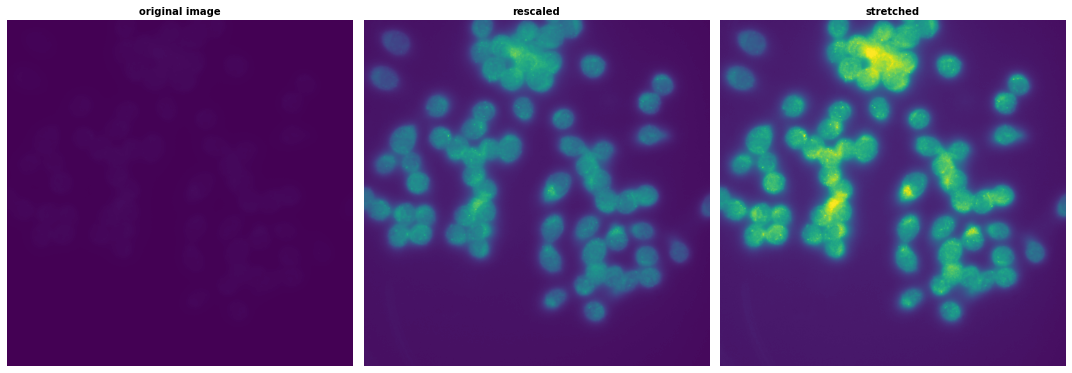

In [18]:
# Plot the raw, rescaled and stretched images
images = [image_2d, image_rescaled, image_stretched]
titles = ["original image", "rescaled", "stretched"]
print(f"Plot of the gene {recipe['c'][0]} from tile {recipe['fov']} and round {recipe['r']}, z slice {z_itgam}")
plot.plot_images(images, titles=titles)

Here, the original image doesn't show anything. Why?
How do the images get read into big fish?
Do the channels get split / are they split like they should?

The above image needs a legend. Is green just a higher intensity of spots?

(2048, 2048)
smfish
 min: 60
 max: 2626 

smfish rescaled
 min: 0
 max: 65535 

smfish stretched
 min: 0
 max: 65535
Plot of the gene Notch2 from tile 0 and round 3, z slice 100


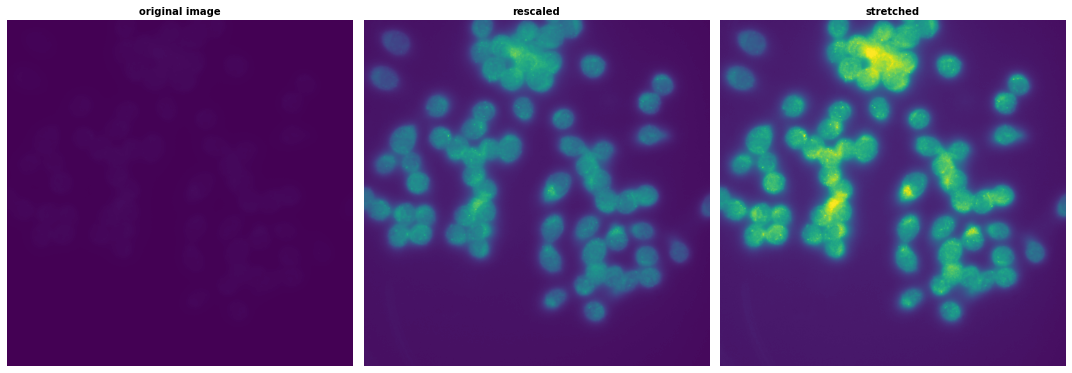

In [19]:
# For Notch2
image_2d = image[z_notch2]
print(image_2d.shape)

print("smfish")
print("\r min: {0}".format(image_2d.min()))
print("\r max: {0}".format(image_2d.max()), "\n")

image_rescaled = stack.rescale(image_2d, channel_to_stretch=None)
print("smfish rescaled")
print("\r min: {0}".format(image_rescaled.min()))
print("\r max: {0}".format(image_rescaled.max()), "\n")

image_stretched = stack.rescale(image_2d, channel_to_stretch=0)
print("smfish stretched")
print("\r min: {0}".format(image_stretched.min()))
print("\r max: {0}".format(image_stretched.max()))

# Plot the raw, rescaled and stretched images
images = [image_2d, image_rescaled, image_stretched]
titles = ["original image", "rescaled", "stretched"]
print(f"Plot of the gene {recipe['c'][1]} from tile {recipe['fov']} and round {recipe['r']}, z slice {z_notch2}")
plot.plot_images(images, titles=titles)

/home/mauri/miniforge3/envs/bigfish_env/lib/python3.6/site-packages/skimage/filters/rank/generic.py:183: UserWarning: Bad rank filter performance is expected due to a large number of bins (2627), equivalent to an approximate bitdepth of 11.4.
  out_dtype)


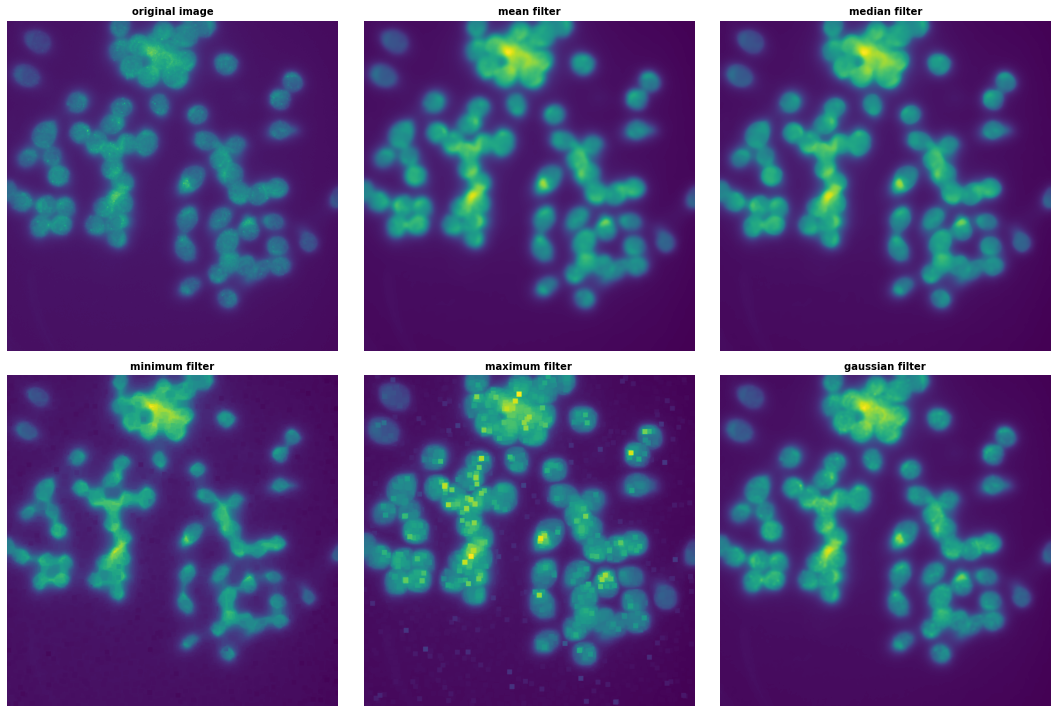

In [20]:
# Apply a filter and use the filter to subtract background
image_2d_mean = stack.mean_filter(image_2d, kernel_shape="square", kernel_size=30)
image_2d_median = stack.median_filter(image_2d, kernel_shape="square", kernel_size=30)
image_2d_min = stack.minimum_filter(image_2d, kernel_shape="square", kernel_size=30)
image_2d_max = stack.maximum_filter(image_2d, kernel_shape="square", kernel_size=30)

image_2d_gaussian = stack.gaussian_filter(image_2d, sigma=5)

images = [image_2d, image_2d_mean, image_2d_median, image_2d_min, image_2d_max, image_2d_gaussian]
titles = ["original image", "mean filter", "median filter", "minimum filter", "maximum filter", "gaussian filter"]
plot.plot_images(images, rescale=True, titles=titles)


